In [4]:
# -*- coding: utf-8 -*-
#"""
#Created on Thu Jun  1 12:39:57 2023
#@author: maminian
#"""

import pandas
from matplotlib import pyplot as plt
import numpy as np
import geopandas
import urllib, urllib3
import requests
import json

### Western Wind Data

/var/folders/s_/2zzdv8gd1vsd1hk5p2gfzsqn58bzxq/T/ipykernel_75748/2801798649.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


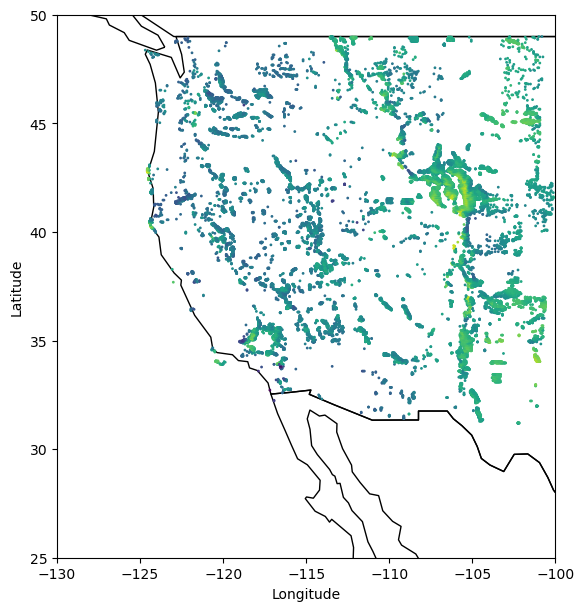

In [2]:
fig,ax = plt.subplots(figsize=(8,6), constrained_layout=True)

# world map
world_gdf = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_gdf = world_gdf[world_gdf['continent'] == 'North America']

world_gdf.plot(ax=ax, facecolor=[0,0,0,0], edgecolor='k')

gdf = geopandas.read_file('Western_Wind_Dataset')

gdf.plot(column='CAPACITY F', ax=ax, s=1)

ax.set(xlabel='Longitude', ylabel='Latitude', xlim=[-130,-100], ylim=[25, 50])
ax.set()
#fig.savefig("wind_thingy.png")
fig.show()

### Precipitation Data

/var/folders/s_/2zzdv8gd1vsd1hk5p2gfzsqn58bzxq/T/ipykernel_77786/3835912290.py:156: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


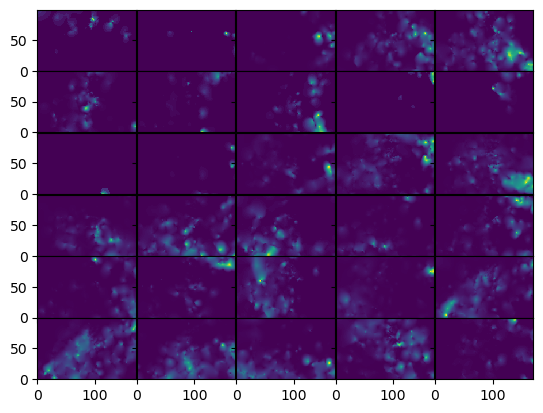

In [18]:
#!/usr/bin/python

'''
ACIS-WS Sample Code --> Spatial summary of grid data
Sum of daily July precipitation projected for 2040
over the state California
using climate model:  CRCM + CGCM3 (grid number 6).
For more information: http://rcc-acis.org/docs_webservices.html
The result is climate map (.png) showing sum of precipitation
in July at each California gridpoint.
'''


#######################################
#Import modules required by Acis
import urllib

import json
#######################################
#######################################
#Import plotting tools
import base64
#######################################
#Set Acis data server
base_url = "http://data.rcc-acis.org/"
#######################################
#Acis WebServices functions
#######################################
def make_request(url,params) :
    data = json.dumps(params)
    data_bytes = bytes(data, 'utf-8') # one weird trick
    
    req = urllib.request.Request(url,
    data=data_bytes,
    headers={"Content-Type":"application/json"})
    try:
        response = urllib.request.urlopen(req)
        return json.loads(response.read())
    except urllib.request.HTTPError as error:
        if error.code == 400 : print(error.msg)
    print(urllib.request.HTTPError)

def GridData(params, server="GridData"):
    return make_request(base_url+server, params)

##################################################
#Map code using Cairo
#http://cairoplot.sourceforge.net/tutorials.html
###################################################
def place_text(ctx,txt,j='l',v='b') :
        _,_,w,h,_,_ = ctx.text_extents(txt)
        if   v == 'b' : h = 0
        elif v == 'm' : h = h/2
        elif v == 't' : h = h
        if   j == 'l' : w = 0
        elif j == 'c' : w = -w/2
        elif j == 'r' : w = -w
        ctx.rel_move_to(w,h)
        ctx.show_text(txt)

def add_legend(ctx,image_info) :
    #ctx.set_matrix(cairo.Matrix(yy=-1,y0=height))
    if image_info['size'][0]<301:
        ctx.set_font_size(8.)
        w = image_info['size'][0]/(len(image_info['cmap']) + 3)
    elif image_info['size'][0]>300 and image_info['size'][0]<501:
        ctx.set_font_size(10.)
        w = image_info['size'][0]/(len(image_info['cmap'])+2)
    else:
        ctx.set_font_size(12.)
        w = image_info['size'][0]/(len(image_info['cmap'])+2)
    for idx,color in enumerate(image_info['cmap']) :
        ctx.rectangle(idx*w,0,w,10)
        ctx.set_source_rgb(int(color[1:3],16)/255.,int(color[3:5],16)/255.,int(color[5:7],16)/255.)
        ctx.fill_preserve()
        ctx.set_source_rgb(0,0,0)
        ctx.stroke()
    for idx,value in enumerate(image_info['levels']) :
        ctx.move_to((idx+1)*w,10)
        ctx.rel_line_to(0,5)
        ctx.rel_move_to(-2,3)
        if value >0.0 and value < 1.0:
            place_text(ctx,'%.2f'%(value),j='c',v='t')
        else:
            place_text(ctx,'%d'%(value),j='c',v='t')
    ctx.stroke()


def build_figure(image_info, out_name):
    image_offset=0
    image_padding = 0,150
    img_buf = StringIO(image_info['data'][21:].decode('base64'))
    img_buf.seek(0)
    # create input image
    in_img = cairo.ImageSurface.create_from_png(img_buf)
    size = height,width = in_img.get_height(),in_img.get_width()
    pad_w,pad_h = image_padding
    # create output image
    out_img = cairo.ImageSurface(cairo.FORMAT_ARGB32,
        width+pad_w, height+pad_h+image_offset)
    ctx = cairo.Context(out_img)
    # set background color
    ctx.set_source_rgb(255,239,213)
    ctx.paint()
    # place image
    ctx.set_source_surface(in_img,pad_w/2,image_offset)
    ctx.paint()
    # frame image
    ctx.set_line_width(1.0)
    ctx.set_source_rgb(0,0,0)
    ctx.rectangle(pad_w/2,image_offset,width,height)
    ctx.stroke()

    ctx.set_matrix(cairo.Matrix(x0=15+25,y0=image_offset+height+80))
    ctx.set_matrix(cairo.Matrix(x0=15+25,
        y0=image_offset+height+30))
    add_legend(ctx,image_info)

    out_buf = open(out_name,'w')
    out_img.write_to_png(out_buf)


###################################################
#M A I N
###################################################
if __name__ == "__main__":
    #Set parameters for data request
    #levels = [0.2*i for i in range(15)]
    params = {
        "state":"co",
        "sdate":"20200701", # low-tech YYYYMMDD
        "edate":"20200731",
        "grid":1,
        "output":"json",
        "elems":[{"name":"pcpn","smry":"sum"}],
    }
    #Obtain data
    data = GridData(params)
    #Generate png output
    #build_figure(data, 'CA_pcpn_map.png')
    
    from matplotlib import pyplot as plt
    import numpy as np
    #mycm = plt.cm.inferno.copy()
    #mycm.set_under([0,0,0,0])
    
    fig,ax = plt.subplots(6,5, sharex=True, sharey=True, gridspec_kw={'wspace':0.01, 'hspace':0.01})
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            idx = j + ax.shape[1]*i
            
            arr = np.array(data['data'][idx][1], dtype=float)
            arr[arr<0] = np.nan
            ax[i,j].pcolor(arr)
            
    fig.show()

/var/folders/s_/2zzdv8gd1vsd1hk5p2gfzsqn58bzxq/T/ipykernel_77786/404130104.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


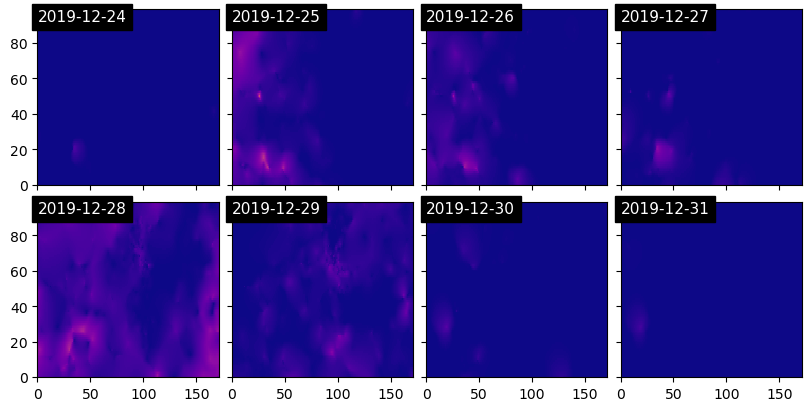

In [30]:
# so that I don't have to re-download.
# Note that the simplified_load.py script needs to 
# be changed to change the focus.
import simplified_load

data = simplified_load.data

    
from matplotlib import pyplot as plt
import numpy as np

fig,ax = plt.subplots(2,4, figsize=(8,4),sharex=True, sharey=True, gridspec_kw={'wspace':0.04, 'hspace':0.04}, constrained_layout=True)
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        idx = j + ax.shape[1]*i
        
        arr = np.array(data['data'][idx][1], dtype=float)
        arr[arr<0] = np.nan
        ax[i,j].pcolor(arr, vmin=0, vmax=2, cmap=plt.cm.plasma)
        ax[i,j].text(0,1,data['data'][idx][0], color='w', fontsize=11, ha='left', va='top', transform=ax[i,j].transAxes, bbox={'facecolor':'k'})     
fig.show()

In [66]:
import acis_example as loader
import copy
import csv
# see 
# https://www.rcc-acis.org/docs_webservices.html 
# (section IV onwards) for parameter values.

params = {
    "state":["CO"],
    "sdate":"20191224", # low-tech YYYYMMDD
    "edate":"20231231",
    "grid":1,
    "output":"json",
    "elems":[{"name":"pcpn","smry":"sum"}],
    "meta":["ll", "elev","pcpn"]
}
#Obtain data
data = loader.GridData(params, server="GridData")

In [67]:
d = pandas.DataFrame(dict([ (k,pandas.Series(v)) for k,v in data.items() ]))

In [50]:
d

,meta,data,smry
0,NaN,"[2019-12-24, [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[[-999, -999, -999, -999, -999, -999, -999, -9..."
1,NaN,"[2019-12-25, [[0.25, 0.25, 0.24, 0.23, 0.22, 0...",NaN
2,NaN,"[2019-12-26, [[0.14, 0.14, 0.14, 0.14, 0.14, 0...",NaN
3,NaN,"[2019-12-27, [[0.01, 0.01, 0.0, 0.0, 0.0, 0.0,...",NaN
4,NaN,"[2019-12-28, [[0.34, 0.34, 0.34, 0.34, 0.33, 0...",NaN
...,...,...,...
1467,NaN,"[2023-12-30, [[-999, -999, -999, -999, -999, -...",NaN
1468,NaN,"[2023-12-31, [[-999, -999, -999, -999, -999, -...",NaN
elev,"[[5062, 4757, 4642, 4810, 4964, 5010, 5046, 51...",NaN,NaN
lat,"[[36.958333, 36.958333, 36.958333, 36.958333, ...",NaN,NaN


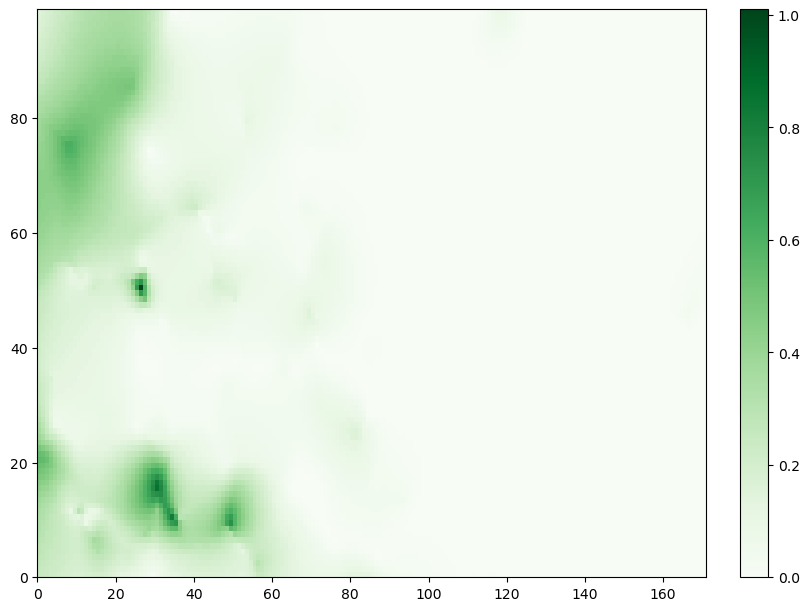

In [205]:


fig,ax = plt.subplots(figsize=(8,6), constrained_layout=True)
p = d.loc[1]['data']
precip = np.asarray(p[1])

# world map
world_gdf = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_gdf = world_gdf[world_gdf['continent'] == 'North America']

#world_gdf.plot(ax=ax, facecolor=[0,0,0,0], edgecolor='k')
c = plt.pcolormesh(precip, cmap ='Greens')
#ax.set(xlabel='Longitude', ylabel='Latitude', xlim=[-109.1,-102], ylim=[36.96, 41.04])
plt.colorbar(c)

### Elevation

In [198]:
elev = np.asarray(d.loc['elev']['meta'])
lat = np.asarray(d.loc['lat']['meta'])
lon = np.asarray(d.loc['lon']['meta'])
#elev = elev.flatten()
#lat = lat.flatten()
#lon = lon.flatten()

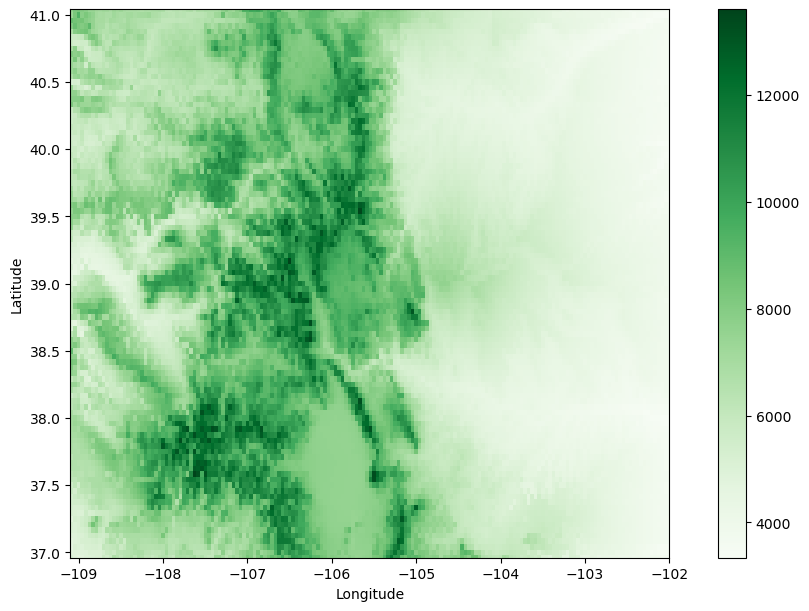

In [204]:
fig,ax = plt.subplots(figsize=(8,6), constrained_layout=True)

# world map
world_gdf = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_gdf = world_gdf[world_gdf['continent'] == 'North America']

#world_gdf.plot(ax=ax, facecolor=[0,0,0,0], edgecolor='k')
ax.set(xlabel='Longitude', ylabel='Latitude', xlim=[-109.1,-102], ylim=[36.96, 41.04])
c = plt.pcolormesh(lon,lat,elev, cmap ='Greens')
plt.colorbar(c)
plt.show()